In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [ ]:
with open('preprocessed_movie.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    df_movies = pd.DataFrame(reader)
df_ratings = pd.read_csv('rating.csv')
df_movies['movieId'] = df_movies['movieId'].astype('int64')

In [93]:
def parse_embeddings(embedding_str):
    embedding_str = str(embedding_str).replace('\n', '')
    embedding_str = embedding_str.strip('[]')
    return np.array([float(x) for x in embedding_str.split() if x])

df_movies['embedding'] = df_movies['embedding'].apply(parse_embeddings)

In [94]:
df_ratings['is_relevant'] = df_ratings['rating'].apply(lambda x: int(x >= 3))

Dataset with reduced dimensionality

In [95]:
embeddings_dict = {}
dim = 409

for _, row in df_movies.iterrows():
    emb = row['embedding']
    if emb.shape == (dim,):
      embeddings_dict[row['movieId']] = emb
    else:
      print(f"Improper dimesionality: {row['movieId']}: {emb.shape}")
      embeddings_dict[row['movieId']] = np.zeros(dim)

Filtering the dataset according to amount of users' reviews by 99.99 percentile

In [96]:
user_review_counts = df_ratings.groupby('userId')['rating'].count()

threshold = user_review_counts.quantile(0.9999)
print(f'Threshold for the amount of user\'s reviews: {threshold}')

filtered_users = user_review_counts[user_review_counts >= threshold].index

df_ratings = df_ratings[df_ratings['userId'].isin(filtered_users)].drop(['timestamp'], axis=1)

Threshold for the amount of user's reviews: 4253.794399996928


About 2.000.000 -> 78.086 entries

In [97]:
df_ratings

,userId,movieId,rating,is_relevant
1225775,8405,1,5.0,1
1225776,8405,2,3.0,1
1225777,8405,3,2.5,0
1225778,8405,5,1.5,0
1225779,8405,6,4.0,1
...,...,...,...,...
19068382,131904,124292,3.0,1
19068383,131904,124867,3.5,1
19068384,131904,128488,1.5,0
19068385,131904,129340,3.5,1


In [98]:
stats = {}
for user_id, group in df_ratings.groupby('userId'):
    relevant_movies = group[group['is_relevant'] == 1]['movieId'].tolist()
    irrelevant_movies = group[group['is_relevant'] == 0]['movieId'].tolist()
    stats[user_id] = (relevant_movies, irrelevant_movies)

train = {}
test = {}
for el in stats.items():
  user_id = el[0]
  relevant = el[1][0]
  irrelevant = el[1][1]

  # 50% for train set and 50% for test set
  train_relevant = np.random.choice(relevant, int(len(relevant) * 0.5)).tolist()
  train_irrelevant = np.random.choice(irrelevant, int(len(irrelevant) * 0.5)).tolist()
  test_relevant = list(set(relevant).difference(set(train_relevant)))
  test_irrelevant = list(set(irrelevant).difference(set(train_irrelevant)))

  train[user_id] = (train_relevant, train_irrelevant)
  test[user_id] = (test_relevant, test_irrelevant)


In [ ]:
profiles = {}

def build_profile(lambda_param):
  ratings_dict = {}
  for _, row in df_ratings.iterrows():
      ratings_dict[(row['userId'], row['movieId'])] = row['rating']

  embeddings_dict = {}
  for _, row in df_movies.iterrows():
      embeddings_dict[row['movieId']] = row['embedding']

  for user_id, (relevant, irrelevant) in train.items():
      good_profile = np.zeros(dim)
      good_weights = 0
      bad_profile = np.zeros(dim)
      bad_weights = 0

      for movie_id in relevant:
          try:
              rating = ratings_dict[(user_id, movie_id)]
              emb = embeddings_dict[movie_id]

              weight = rating
              good_weights += weight
              if emb.shape[0] == 0:
                continue
              good_profile += emb * weight
          except KeyError:
              continue

      for movie_id in irrelevant:
          try:
              rating = ratings_dict[(user_id, movie_id)]
              emb = embeddings_dict[movie_id]

              weight = rating
              bad_weights += weight
              if emb.shape[0] == 0:
                continue
              bad_profile += emb * weight
          except KeyError:
              continue

      good_profile = good_profile / good_weights if good_weights > 0 else good_profile
      bad_profile = bad_profile / bad_weights if bad_weights > 0 else bad_profile

      profiles[user_id] = good_profile - lambda_param * bad_profile

In [100]:
from sklearn.metrics import ndcg_score
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def eval(k=50):
    ndcg_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    ap_scores = []
    rr_scores = []

    recommendations_outside_test = 0
    total_recommendations = 0
    recommendations_in_train = 0

    for user_id, (test_relevant, test_irrelevant) in test.items():
        train_movies = set(train[user_id][0] + train[user_id][1])

        all_movies = set(embeddings_dict.keys())
        candidate_movies = list(all_movies - train_movies)

        user_emb = profiles[user_id].reshape(1, -1)
        candidate_embs = [embeddings_dict.get(mid, np.zeros(dim)) for mid in candidate_movies]
        similarities = cosine_similarity(user_emb, candidate_embs)[0]

        top_indices = np.argsort(similarities)[::-1][:k]
        recommendations = [candidate_movies[i] for i in top_indices]

        rel_vector = [1 if mid in test_relevant else 0 for mid in recommendations]

        precision = sum(rel_vector) / k
        precision_scores.append(precision)

        recall = sum(rel_vector) / len(test_relevant) if test_relevant else 0
        recall_scores.append(recall)

        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)

        ap = calculate_ap(rel_vector, test_relevant)
        ap_scores.append(ap)

        rr = calculate_rr(rel_vector)
        rr_scores.append(rr)

        test_movies = test_relevant + test_irrelevant
        y_true = [1 if mid in test_relevant else 0 for mid in test_movies]

        test_embs = [embeddings_dict.get(mid, np.zeros(dim)) for mid in test_movies]
        test_similarities = cosine_similarity(user_emb, test_embs)[0]

        if sum(y_true) > 0:
            ndcg = ndcg_score([y_true], [test_similarities], k=min(k, len(y_true)))
            ndcg_scores.append(ndcg)

        total_recommendations += k

        recommendations_outside_test += len(set(recommendations) - set(test_movies))

        recommendations_in_train += len(set(recommendations) & train_movies)

    print(f"Precision@{k}: {np.mean(precision_scores):.4f}")
    print(f"Recall@{k}: {np.mean(recall_scores):.4f}")
    print(f"F1@{k}: {np.mean(f1_scores):.4f}")
    print(f"AP@{k}: {np.mean(ap_scores):.4f}")
    print(f"RR{k}: {np.mean(rr_scores):.4f}")

    if ndcg_scores:
        print(f"NDCG@{k}: {np.mean(ndcg_scores):.4f}")

    precision_arr.append(np.mean(precision_scores))
    recall_arr.append(np.mean(recall_scores))
    f1_arr.append(np.mean(f1_scores))
    ap_arr.append(np.mean(ap_scores))
    rr_arr.append(np.mean(rr_scores))
    ndcg_arr.append(np.mean(ndcg_scores) if ndcg_scores else 0)
    return {
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'ap': np.mean(ap_scores),
        'rr': np.mean(rr_scores),
        'ndcg': np.mean(ndcg_scores) if ndcg_scores else 0,
        'outside_test_ratio': recommendations_outside_test/total_recommendations,
        'in_train_ratio': recommendations_in_train/total_recommendations
    }

def calculate_ap(rel_vector, test_relevant, k=None):
    if k is None:
        k = len(rel_vector)
    rel_vector = rel_vector[:k]

    if sum(rel_vector) == 0:
        return 0.0

    precision_at_i = []
    relevant_count = 0

    for i, rel in enumerate(rel_vector):
        if rel == 1:
            relevant_count += 1
            precision_at_i.append(relevant_count / (i + 1))

    total_relevant = min(len(test_relevant), relevant_count)

    return sum(precision_at_i) / total_relevant

def calculate_rr(rel_vector, k=None):
    if k is None:
        k = len(rel_vector)
    rel_vector = rel_vector[:k]

    for i, rel in enumerate(rel_vector):
        if rel == 1:
            return 1.0 / (i + 1)
    return 0.0

In [103]:
lambdas = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.]
precision_arr = []
f1_arr = []
recall_arr = []
ndcg_arr = []
ap_arr = []
rr_arr = []

for lambda_param in lambdas:
  profiles = {}
  build_profile(lambda_param)
  print(f'lambda: {lambda_param}')
  eval()
  print()

lambda: 0.0
Precision@50: 0.2243
Recall@50: 0.0055
F1@50: 0.0107
AP@50: 0.2561
RR50: 0.2990
NDCG@50: 0.7692

lambda: 0.1
Precision@50: 0.2200
Recall@50: 0.0055
F1@50: 0.0106
AP@50: 0.2526
RR50: 0.2905
NDCG@50: 0.7741

lambda: 0.2
Precision@50: 0.2243
Recall@50: 0.0055
F1@50: 0.0107
AP@50: 0.2464
RR50: 0.2883
NDCG@50: 0.7850

lambda: 0.3
Precision@50: 0.2229
Recall@50: 0.0056
F1@50: 0.0108
AP@50: 0.2424
RR50: 0.2912
NDCG@50: 0.7966

lambda: 0.4
Precision@50: 0.2057
Recall@50: 0.0052
F1@50: 0.0101
AP@50: 0.2415
RR50: 0.3261
NDCG@50: 0.8084

lambda: 0.5
Precision@50: 0.2057
Recall@50: 0.0052
F1@50: 0.0101
AP@50: 0.2332
RR50: 0.3182
NDCG@50: 0.8035

lambda: 0.6
Precision@50: 0.1957
Recall@50: 0.0051
F1@50: 0.0098
AP@50: 0.2275
RR50: 0.2958
NDCG@50: 0.8223

lambda: 0.7
Precision@50: 0.1957
Recall@50: 0.0050
F1@50: 0.0096
AP@50: 0.2236
RR50: 0.2932
NDCG@50: 0.8268

lambda: 0.8
Precision@50: 0.1829
Recall@50: 0.0045
F1@50: 0.0086
AP@50: 0.2171
RR50: 0.3163
NDCG@50: 0.8302

lambda: 0.9
Precisi

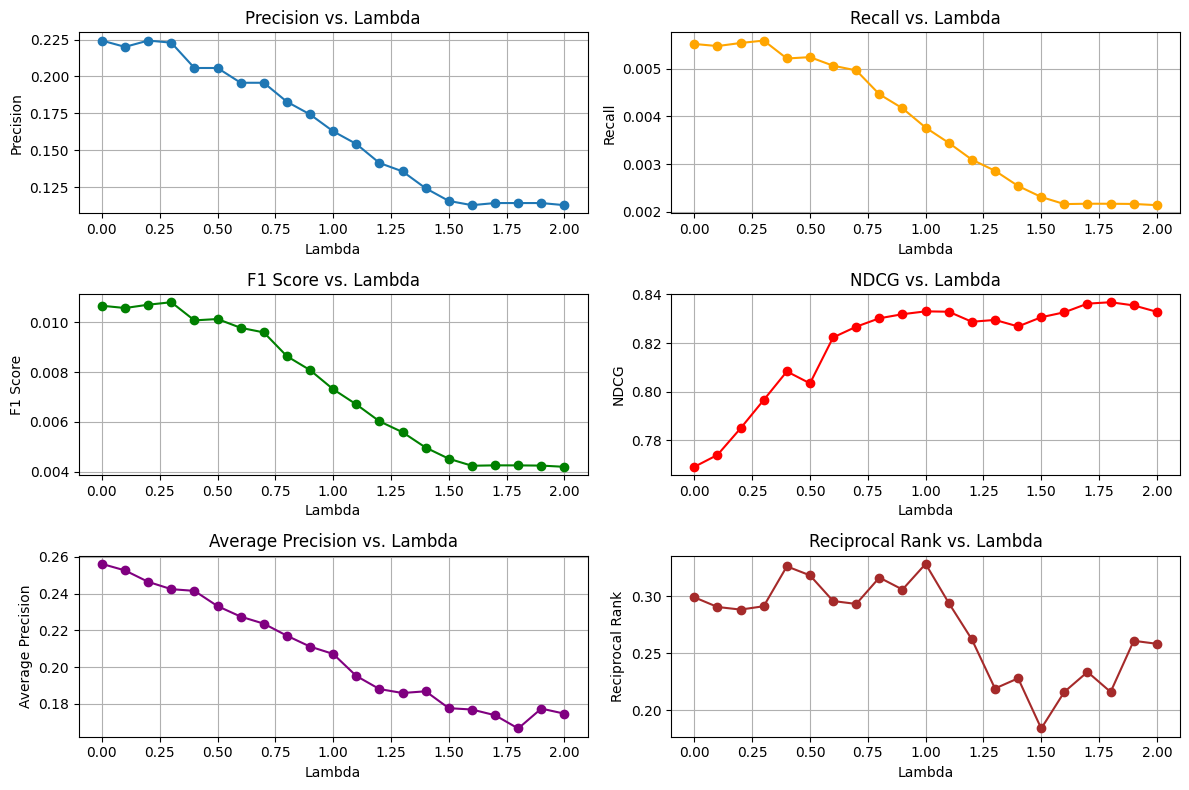

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(lambdas, precision_arr, marker='o')
plt.title('Precision vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(lambdas, recall_arr, marker='o', color='orange')
plt.title('Recall vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.grid()

plt.subplot(3, 2, 3)
plt.plot(lambdas, f1_arr, marker='o', color='green')
plt.title('F1 Score vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(lambdas, ndcg_arr, marker='o', color='red')
plt.title('NDCG vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('NDCG')
plt.grid()

plt.subplot(3, 2, 5)
plt.plot(lambdas, ap_arr, marker='o', color='purple')
plt.title('Average Precision vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average Precision')
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(lambdas, rr_arr, marker='o', color='brown')
plt.title('Reciprocal Rank vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Reciprocal Rank')
plt.grid()

plt.tight_layout()
plt.show()

In [106]:
import faiss
from sklearn.metrics import ndcg_score


movie_embeddings = np.vstack(df_movies['embedding'].values).astype('float32')
movie_ids = df_movies['movieId'].values

dim = movie_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
faiss.normalize_L2(movie_embeddings)
index.add(movie_embeddings)

train = {}
test = {}
THRESHOLD = 3.0

for user_id, group in df_ratings.groupby('userId'):
    relevant = group[group['rating'] >= THRESHOLD]['movieId'].tolist()
    irrelevant = group[group['rating'] < THRESHOLD]['movieId'].tolist()

    train_relevant = relevant[:int(0.5*len(relevant))]
    test_relevant = relevant[int(0.5*len(relevant)):]

    train_irrelevant = irrelevant[:int(0.5*len(irrelevant))]
    test_irrelevant = irrelevant[int(0.5*len(irrelevant)):]

    train[user_id] = {'relevant': train_relevant, 'irrelevant': train_irrelevant}
    test[user_id] = {'relevant': test_relevant, 'irrelevant': test_irrelevant}

def precision_at_k(relevant, recommended, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(relevant, recommended, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if relevant else 0

def f1_at_k(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def ap_at_k(relevant, recommended, k):
    precision_sum = 0
    relevant_count = 0

    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            relevant_count += 1
            precision_sum += relevant_count / (i + 1)

    return precision_sum / min(len(relevant), k) if relevant else 0

def rr_at_k(relevant, recommended, k):
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            return 1.0 / (i + 1)
    return 0

def evaluate_ann(k=50):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    ap_scores = []
    rr_scores = []
    ndcg_scores = []

    for user_id, user_data in test.items():
        train_relevant = train[user_id]['relevant']
        train_irrelevant = train[user_id]['irrelevant']
        test_relevant = test[user_id]['relevant']

        relevant_embs = movie_embeddings[[np.where(movie_ids == mid)[0][0] for mid in train_relevant]]
        user_embedding = np.mean(relevant_embs, axis=0).astype('float32')
        user_embedding = user_embedding.reshape(1, -1)
        faiss.normalize_L2(user_embedding)

        distances, indices = index.search(user_embedding, k)
        recommendations = movie_ids[indices[0]]

        viewed = set(train_relevant + train_irrelevant)
        recommendations = [mid for mid in recommendations if mid not in viewed][:k]

        precision = precision_at_k(test_relevant, recommendations, k)
        recall = recall_at_k(test_relevant, recommendations, k)
        f1 = f1_at_k(precision, recall)
        ap = ap_at_k(test_relevant, recommendations, k)
        rr = rr_at_k(test_relevant, recommendations, k)

        y_true = [1 if mid in test_relevant else 0 for mid in recommendations]
        if sum(y_true) > 0:
            y_score = list(range(len(recommendations), 0, -1))
            ndcg = ndcg_score([y_true], [y_score], k=k)
        else:
            ndcg = 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        ap_scores.append(ap)
        rr_scores.append(rr)
        ndcg_scores.append(ndcg)

    metrics = {
        'precision@k': np.mean(precision_scores),
        'recall@k': np.mean(recall_scores),
        'f1@k': np.mean(f1_scores),
        'ap@k': np.mean(ap_scores),
        'rr@k': np.mean(rr_scores),
        'ndcg@k': np.mean(ndcg_scores)
    }

    return metrics

results = evaluate_ann(k=50)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

precision@k: 0.1214
recall@k: 0.0035
f1@k: 0.0068
ap@k: 0.0284
rr@k: 0.3210
ndcg@k: 0.4857
